In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [6]:
sales = pd.read_csv("rollingsales_brooklyn.csv")
print(len(sales))
print(sales.dtypes)

23373
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


In [7]:
# Format columns
def format_num(s):
    return float(s.replace("$","").replace(",",""))

# Strip extra whitespace from strings
# Could also go further and convert everything to lowercase, collapse extra internal spaces, etc...
str_cols = sales.select_dtypes(["object"])
sales[str_cols.columns] = str_cols.apply(lambda x: x.str.strip())

# Format numbers that have dollar signs and or commas so they can actually be treated as numbers
num_cols = sales[["LAND SQUARE FEET", "SALE PRICE", "GROSS SQUARE FEET"]]
sales[num_cols.columns] = num_cols.apply(lambda x: x.apply(format_num,True))

# Turn date string into an actual date object
sales["SALE DATE"] = pd.to_datetime(sales["SALE DATE"])

/var/folders/q7/gqrkvw7x1w9fqtxv3bsjbxwm0000gn/T/ipykernel_4330/802616450.py:12: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  sales[num_cols.columns] = num_cols.apply(lambda x: x.apply(format_num,True))
/var/folders/q7/gqrkvw7x1w9fqtxv3bsjbxwm0000gn/T/ipykernel_4330/802616450.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales["SALE DATE"] = pd.to_datetime(sales["SALE DATE"])


In [8]:
sales.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                 object
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE           

In [9]:
# Select features we are interested in
sales = sales[["NEIGHBORHOOD", "ZIP CODE", "BUILDING CLASS CATEGORY", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT", "SALE PRICE"]]
# Add a new feature for the total square feet
sales["TOTAL SQUARE FEET"] = sales["LAND SQUARE FEET"] + sales["GROSS SQUARE FEET"]
sales.describe()

,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,23373.000000,2.337300e+04,2.337300e+04,23373.000000,2.337300e+04,2.337300e+04
mean,11211.478929,3.558953e+03,3.005280e+03,1681.096436,5.283847e+05,6.564233e+03
std,302.733649,7.830975e+04,2.295111e+04,658.095440,2.821726e+06,8.947425e+04
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,11209.000000,0.000000e+00,0.000000e+00,1901.000000,0.000000e+00,0.000000e+00
50%,11218.000000,1.850000e+03,1.760000e+03,1925.000000,2.500000e+05,3.813000e+03
75%,11230.000000,2.500000e+03,3.000000e+03,1950.000000,6.141970e+05,5.374000e+03
max,11416.000000,7.446955e+06,2.548000e+06,2013.000000,2.769470e+08,8.992663e+06


In [10]:
# Based on the above summary data (and prior EDA!!!), we should get rid of some missing/invalid data
sales = sales[sales["NEIGHBORHOOD"] != ""]
sales = sales[sales["BUILDING CLASS CATEGORY"] != ""]
sales = sales[sales["ZIP CODE"] != 0]
sales = sales[sales["LAND SQUARE FEET"] > 0]
sales = sales[sales["GROSS SQUARE FEET"] > 0]
sales = sales[sales["YEAR BUILT"] > 1900]
sales = sales[sales["SALE PRICE"] > 10000]
sales.describe()

,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,7100.000000,7100.000000,7.100000e+03,7100.000000,7.100000e+03,7.100000e+03
mean,11220.510282,3545.527465,4.778429e+03,1930.475775,1.037613e+06,8.323957e+03
std,11.713995,17405.041830,3.263229e+04,25.204169,4.088284e+06,4.705786e+04
min,11201.000000,396.000000,1.000000e+02,1901.000000,1.100000e+04,8.320000e+02
25%,11210.000000,1890.000000,1.824000e+03,1915.000000,3.900000e+05,3.896000e+03
50%,11220.000000,2077.500000,2.513500e+03,1925.000000,6.000000e+05,4.861500e+03
75%,11230.000000,2715.000000,3.572000e+03,1931.000000,8.800000e+05,6.250000e+03
max,11416.000000,905000.000000,2.548000e+06,2012.000000,2.769470e+08,3.453000e+06


In [11]:
sales["BUILDING CLASS CATEGORY"].value_counts()

BUILDING CLASS CATEGORY
02  TWO FAMILY HOMES                         2785
01  ONE FAMILY HOMES                         1686
03  THREE FAMILY HOMES                        929
07  RENTALS - WALKUP APARTMENTS               899
14  RENTALS - 4-10 UNIT                       197
22  STORE BUILDINGS                           169
30  WAREHOUSES                                 95
27  FACTORIES                                  75
21  OFFICE BUILDINGS                           72
29  COMMERCIAL GARAGES                         60
08  RENTALS - ELEVATOR APARTMENTS              55
37  RELIGIOUS FACILITIES                       21
33  EDUCATIONAL FACILITIES                     12
41  TAX CLASS 4 - OTHER                        10
10  COOPS - ELEVATOR APARTMENTS                 6
35  INDOOR PUBLIC AND CULTURAL FACILITIES       5
26  OTHER HOTELS                                5
32  HOSPITAL AND HEALTH FACILITIES              4
38  ASYLUMS AND HOMES                           3
05  TAX CLASS 1 VACANT LAN

array([[<Axes: title={'center': 'ZIP CODE'}>,
        <Axes: title={'center': 'LAND SQUARE FEET'}>],
       [<Axes: title={'center': 'GROSS SQUARE FEET'}>,
        <Axes: title={'center': 'YEAR BUILT'}>],
       [<Axes: title={'center': 'SALE PRICE'}>,
        <Axes: title={'center': 'TOTAL SQUARE FEET'}>]], dtype=object)

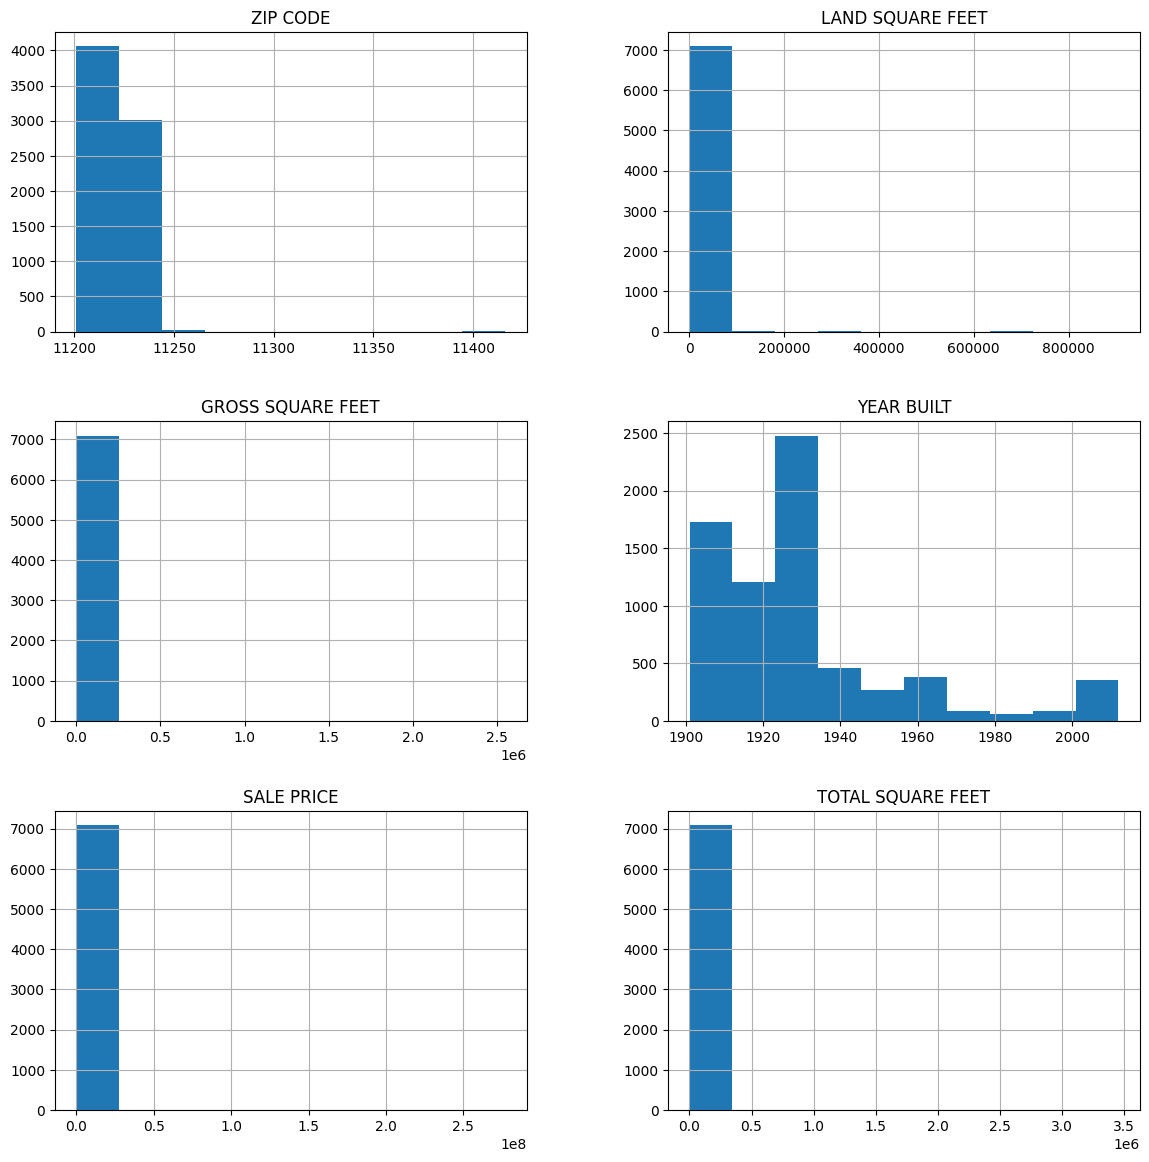

In [12]:
sales.hist(figsize=(14,14))

array([[<Axes: title={'center': '01  ONE FAMILY HOMES'}>,
        <Axes: title={'center': '02  TWO FAMILY HOMES'}>,
        <Axes: title={'center': '03  THREE FAMILY HOMES'}>,
        <Axes: title={'center': '05  TAX CLASS 1 VACANT LAND'}>,
        <Axes: title={'center': '06  TAX CLASS 1 - OTHER'}>],
       [<Axes: title={'center': '07  RENTALS - WALKUP APARTMENTS'}>,
        <Axes: title={'center': '08  RENTALS - ELEVATOR APARTMENTS'}>,
        <Axes: title={'center': '09  COOPS - WALKUP APARTMENTS'}>,
        <Axes: title={'center': '10  COOPS - ELEVATOR APARTMENTS'}>,
        <Axes: title={'center': '11A CONDO-RENTALS'}>],
       [<Axes: title={'center': '14  RENTALS - 4-10 UNIT'}>,
        <Axes: title={'center': '21  OFFICE BUILDINGS'}>,
        <Axes: title={'center': '22  STORE BUILDINGS'}>,
        <Axes: title={'center': '23  LOFT BUILDINGS'}>,
        <Axes: title={'center': '26  OTHER HOTELS'}>],
       [<Axes: title={'center': '27  FACTORIES'}>,
        <Axes: title={'cent

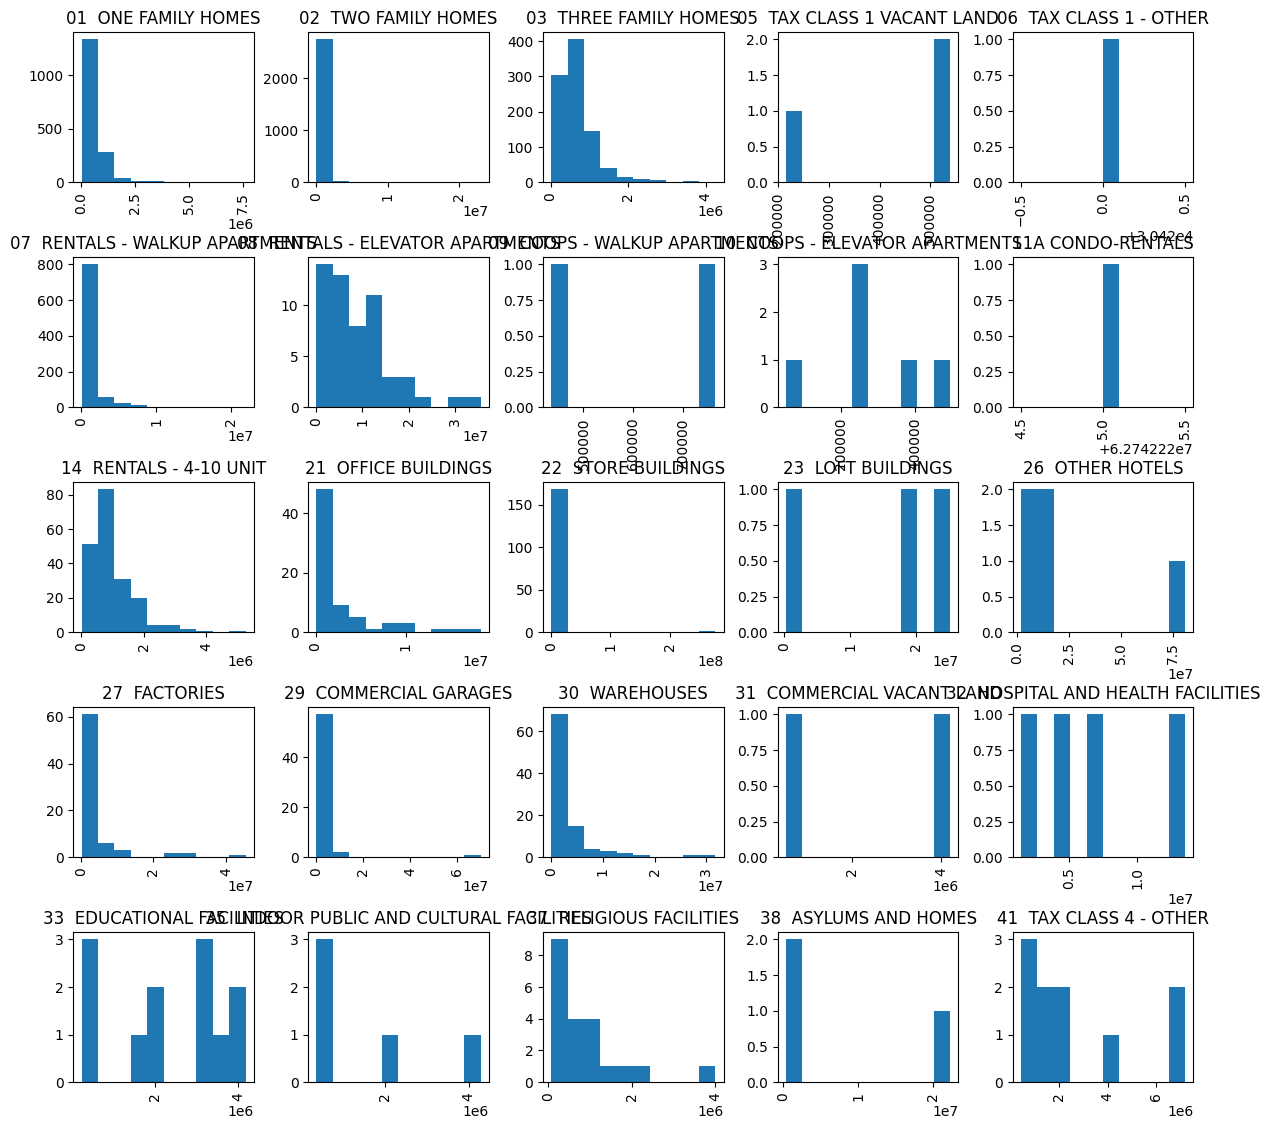

In [13]:
sales.hist(column="SALE PRICE", by="BUILDING CLASS CATEGORY", figsize=(14,14))

array([[<Axes: title={'center': 'SALE PRICE'}>]], dtype=object)

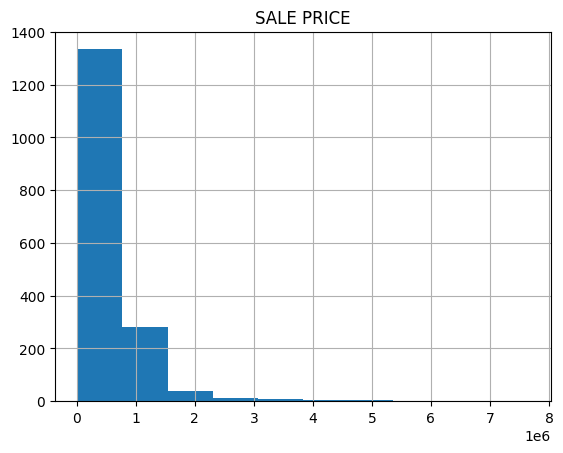

In [14]:
sales[sales["BUILDING CLASS CATEGORY"] == "01  ONE FAMILY HOMES"].hist(column="SALE PRICE")

array([[<Axes: title={'center': 'ZIP CODE'}>,
        <Axes: title={'center': 'LAND SQUARE FEET'}>],
       [<Axes: title={'center': 'GROSS SQUARE FEET'}>,
        <Axes: title={'center': 'YEAR BUILT'}>],
       [<Axes: title={'center': 'SALE PRICE'}>,
        <Axes: title={'center': 'TOTAL SQUARE FEET'}>]], dtype=object)

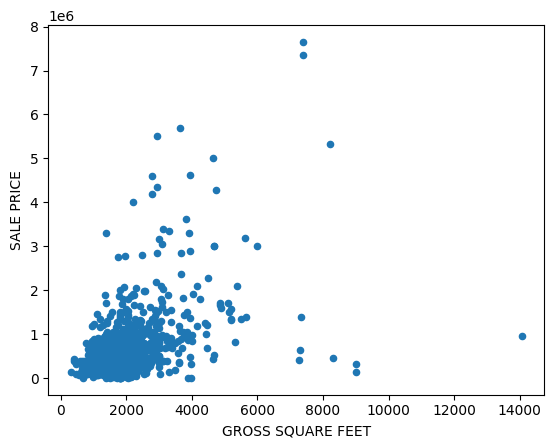

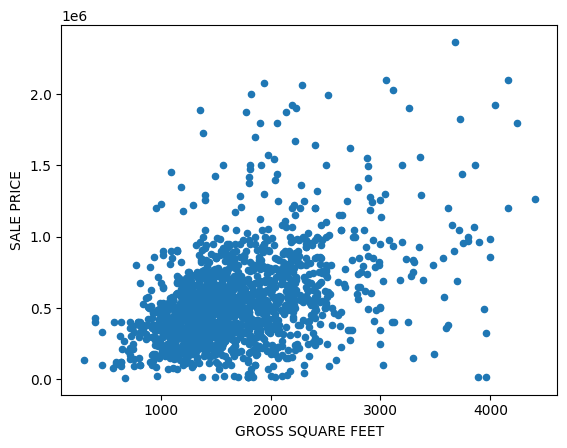

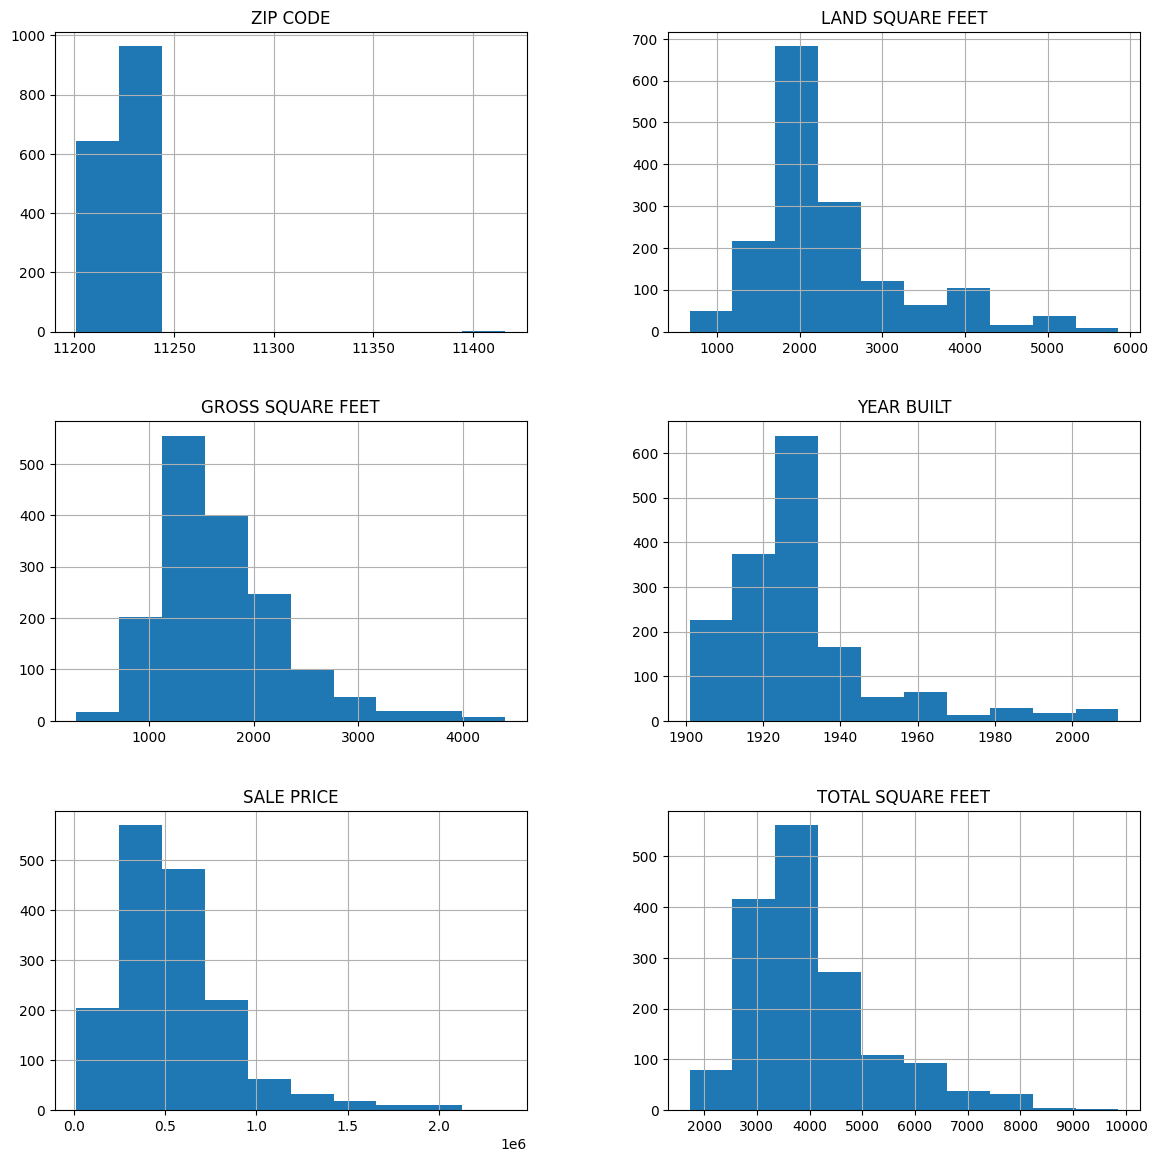

In [15]:
# There are some pretty extreme outliers, let's filter out data more than 3 std devs from mean
single_family = sales[sales["BUILDING CLASS CATEGORY"] == "01  ONE FAMILY HOMES"]

single_family.plot.scatter(x="GROSS SQUARE FEET", y="SALE PRICE")
single_family = single_family[(np.abs(stats.zscore(single_family[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
single_family.plot.scatter(x="GROSS SQUARE FEET", y="SALE PRICE")
single_family.hist(figsize=(14,14))

<Axes: title={'center': 'SALE PRICE'}, xlabel='ZIP CODE'>

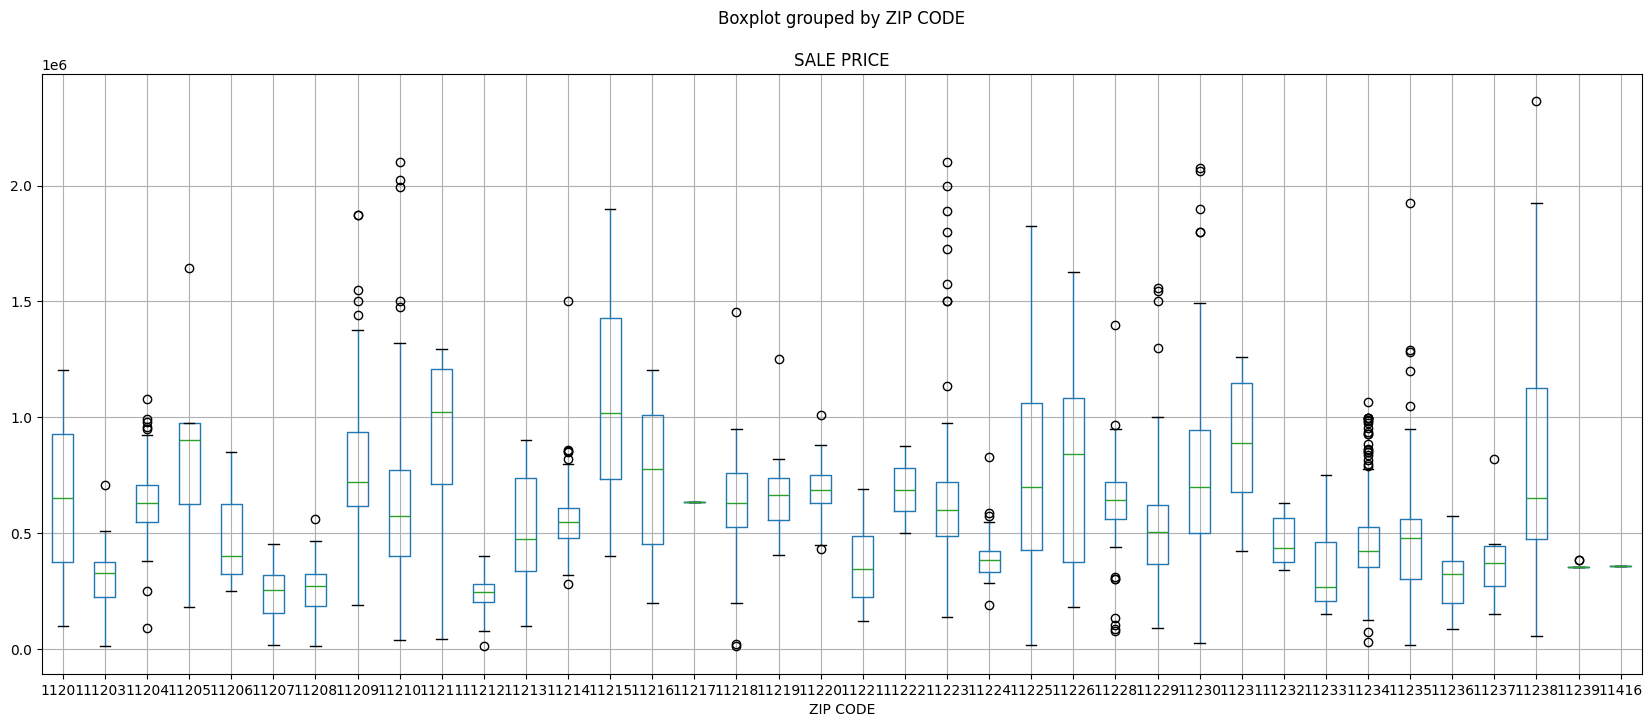

In [16]:
single_family.boxplot(column="SALE PRICE", by="ZIP CODE",figsize=(20,8))

In [17]:
print(single_family["NEIGHBORHOOD"].value_counts())
print(single_family["ZIP CODE"].value_counts())

NEIGHBORHOOD
FLATBUSH-EAST               131
MARINE PARK                 120
MIDWOOD                     100
BAY RIDGE                    93
MADISON                      84
OCEAN PARKWAY-NORTH          75
CANARSIE                     73
DYKER HEIGHTS                71
OLD MILL BASIN               66
GRAVESEND                    62
EAST NEW YORK                60
SHEEPSHEAD BAY               59
BOROUGH PARK                 49
BENSONHURST                  44
GERRITSEN BEACH              43
FLATBUSH-CENTRAL             42
CROWN HEIGHTS                31
OCEAN PARKWAY-SOUTH          30
CYPRESS HILLS                28
MILL BASIN                   28
BERGEN BEACH                 27
FLATLANDS                    27
BEDFORD STUYVESANT           24
FLATBUSH-LEFFERTS GARDEN     23
FLATBUSH-NORTH               20
BATH BEACH                   19
SPRING CREEK                 18
MANHATTAN BEACH              17
BROWNSVILLE                  17
BRIGHTON BEACH               15
CONEY ISLAND               

<Axes: xlabel='TOTAL SQUARE FEET', ylabel='SALE PRICE'>

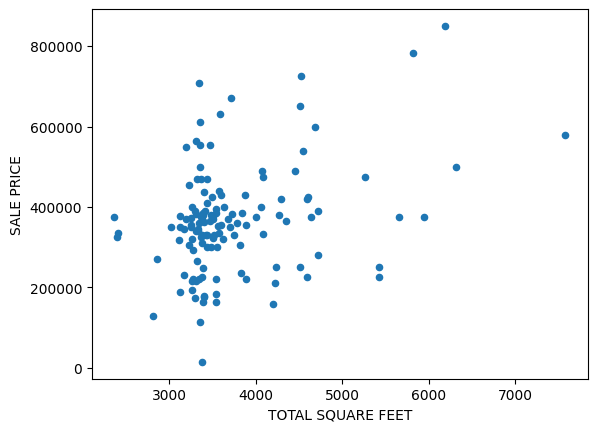

In [18]:
single_fe = single_family[single_family["NEIGHBORHOOD"]=="FLATBUSH-EAST"]
single_fe.plot.scatter(x="TOTAL SQUARE FEET", y="SALE PRICE")

In [19]:
print(sales["NEIGHBORHOOD"].value_counts())
print(sales["ZIP CODE"].value_counts())

NEIGHBORHOOD
BUSHWICK                 491
BEDFORD STUYVESANT       482
EAST NEW YORK            386
BOROUGH PARK             356
CROWN HEIGHTS            337
                        ... 
DOWNTOWN-FULTON FERRY      9
SEAGATE                    8
COBBLE HILL-WEST           7
JAMAICA BAY                1
DOWNTOWN-METROTECH         1
Name: count, Length: 61, dtype: int64
ZIP CODE
11234    459
11207    410
11221    386
11236    299
11208    295
11229    288
11223    274
11228    263
11233    263
11214    251
11220    229
11204    224
11210    217
11230    214
11216    208
11203    206
11235    196
11209    191
11219    189
11215    186
11218    168
11213    160
11237    160
11206    153
11212    148
11226    146
11238    116
11211    114
11225    113
11222     99
11205     99
11232     84
11231     67
11201     63
11217     61
11239     38
11224     35
11249     25
11416      3
Name: count, dtype: int64


<Axes: xlabel='TOTAL SQUARE FEET', ylabel='SALE PRICE'>

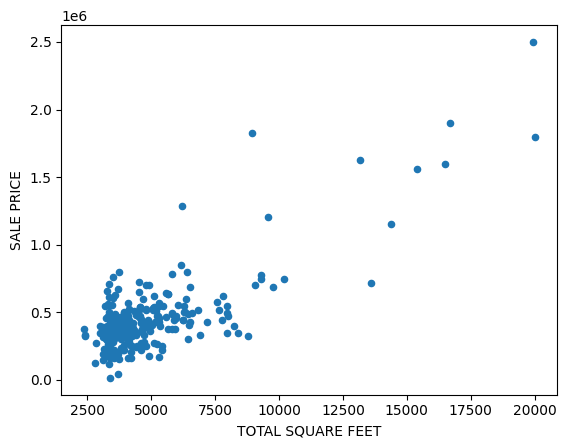

In [20]:
# Total square feet is better, but still not great
# The data comes from 61 different neighborhoods, and as they say "location location location!"...so
# the neighborhood probably has a pretty big effect on price. Let's look at just a single neighborhood.
sales_fe = sales[sales["NEIGHBORHOOD"]=="FLATBUSH-EAST"]
sales_fe = sales_fe[(np.abs(stats.zscore(sales_fe[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)]
sales_fe.plot.scatter(x="TOTAL SQUARE FEET", y="SALE PRICE")